In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [79]:
def predict_tflite(interpreter, x_test):

  # Initialize the TFLite interpreter
  # interpreter = tf.lite.Interpreter(model_content=tflite_model)
  # interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # If required, quantize the input layer (from float to integer)
  input_scale, input_zero_point = input_details["quantization"]
  if (input_scale, input_zero_point) != (0.0, 0):
    x_test = x_test / input_scale + input_zero_point
    print(input_zero_point, input_scale)
    x_test = x_test.astype(input_details["dtype"])
  
  # Invoke the interpreter
  interpreter.set_tensor(input_details["index"], x_test)
  interpreter.invoke()
  y_pred = interpreter.get_tensor(output_details["index"])[0]
  # If required, dequantized the output layer (from integer to float)
  output_scale, output_zero_point = output_details["quantization"]
  if (output_scale, output_zero_point) != (0.0, 0):
    print(output_zero_point, output_scale)
    y_pred = y_pred.astype(np.float32)
    print(y_pred)
    y_pred = (y_pred - output_zero_point) * output_scale
    print(y_pred)

  return y_pred

def evaluate_tflite(tflite_model, x_test, y_true):
  global model
  y_pred = predict_tflite(tflite_model, x_test)
  loss_function = tf.keras.losses.get(model.loss)
  loss = loss_function(y_true, y_pred).numpy()
  return loss


In [58]:
f_model = "Models/_Lite/"
# Load the TFLite model and allocate tensors.
model = tf.lite.Interpreter(model_path=f_model+"WaveNet0.5.tflite")
model.allocate_tensors()
modelq = tf.lite.Interpreter(model_path=f_model+"WaveNet0.5quantized.tflite")
modelq.allocate_tensors()

# # Get input and output tensors.
# input_details = model.get_input_details()
# output_details = model.get_output_details()


In [52]:
with open("PrepedData/Test/LPG4XTestFlat.npy", "rb") as f:
    XTest = np.load(f)
with open("PrepedData/Test/LPG4YTestFlat.npy", "rb") as f:
    YTest = np.load(f)

-41 0.15372547507286072
-89 0.023268215358257294
[-95. -82.  -8. -48. -70. -51.   8. -38. -87. -59.   2. -58. -77. -39.
  82. -86.]
[-0.13960929  0.1628775   1.8847255   0.95399684  0.44209608  0.88419217
  2.257017    1.186679    0.04653643  0.69804645  2.1174076   0.72131467
  0.27921858  1.1634108   3.978865    0.06980465]
-41 0.15372547507286072
-89 0.023268215358257294
[-88. -82.  -2. -42. -63. -23.  -7. -96. -81. -56. -14. -75. -93. -47.
  64. -80.]
[ 0.02326822  0.1628775   2.0243347   1.0936061   0.6049736   1.5357022
  1.9079937  -0.1628775   0.18614572  0.7678511   1.7451161   0.325755
 -0.09307286  0.97726506  3.560037    0.20941395]
-41 0.15372547507286072
-89 0.023268215358257294
[-91. -82.   7. -43. -78.  -6.  21. -79. -84. -65.   7. -53. -84. -51.
  22. -77.]
[-0.04653643  0.1628775   2.2337487   1.0703379   0.25595036  1.9312619
  2.5595038   0.23268215  0.11634108  0.55843717  2.2337487   0.8376558
  0.11634108  0.88419217  2.582772    0.27921858]
-41 0.153725475072860

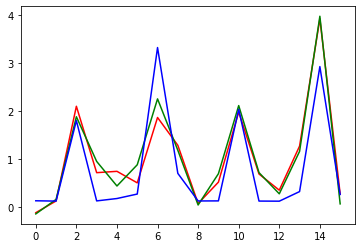

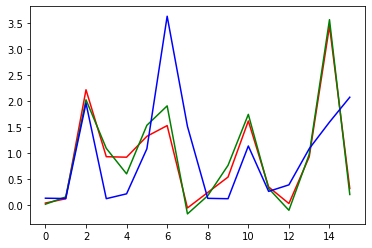

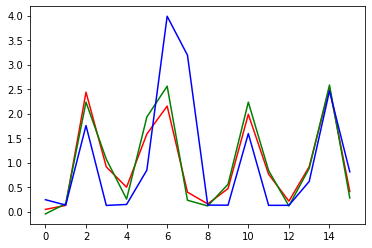

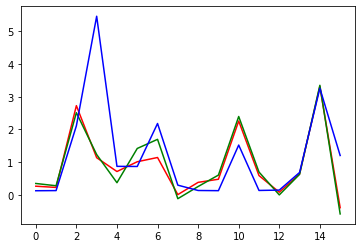

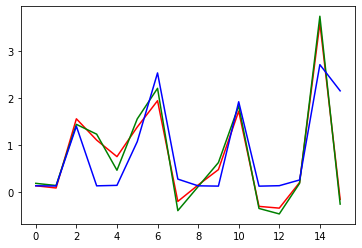

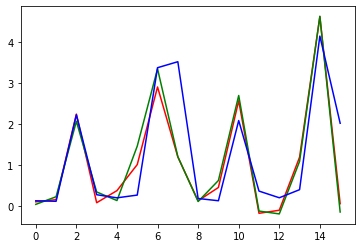

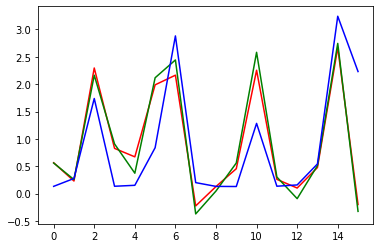

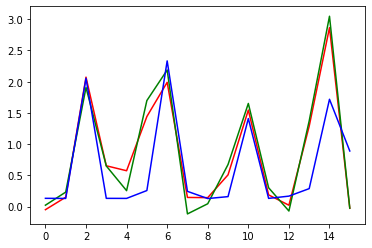

<Figure size 432x288 with 0 Axes>

In [53]:
for i in range(min(len(XTest),8)):
    output_data = predict_tflite(model,XTest[i:i+1])
    output_dataq = predict_tflite(modelq,XTest[i:i+1])
    # model.set_tensor(input_details[0]['index'], XTest[i:i+1])
    # model.invoke()
    # output_data = model.get_tensor(output_details[0]['index'])

    plt.plot(output_data.flatten(),'r')
    plt.plot(output_dataq.flatten(),'g')
    plt.plot(YTest[i],'b')
    plt.figure()

-41 0.15372547507286072
-104 0.01824425347149372
[-104. -105.  -22.  -96. -103.  -79.  -16.  -71.  -97. -108.  -38.  -89.
  -94.  -67.    5.  -72.]
[ 0.         -0.01824425  1.4960288   0.14595403  0.01824425  0.45610633
  1.6054943   0.6020604   0.12770978 -0.07297701  1.2041208   0.2736638
  0.18244253  0.6750374   1.9886236   0.5838161 ]


<Figure size 432x288 with 0 Axes>

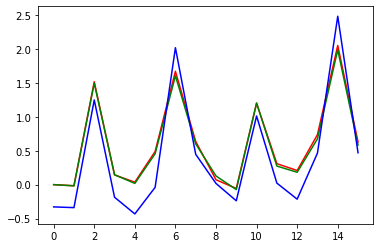

<Figure size 432x288 with 0 Axes>

In [84]:
i = 0
output_data = predict_tflite(model,np.ones((1,40,4),dtype="f4")*i)
output_dataq  = predict_tflite(modelq,np.ones((1,40,4),dtype="f4")*i)
# model.set_tensor(input_details[0]['index'], XTest[i:i+1])
# model.invoke()
# output_data = model.get_tensor(output_details[0]['index'])

plt.plot(output_data.flatten(),'r')
plt.plot(output_dataq.flatten(),'g')

b1 = [-0.328228,      -0.338961,      1.249130,       -0.185813, 
-0.431749,      -0.039990,      2.019296,       0.447423, 
0.017445,       -0.238171,      1.012318,       0.022367,
-0.214301,      0.465246,       2.483241,       0.470250, ]
b1 = [-0.106038,      -0.033162,      2.104842,       0.229635, 
0.493782,       0.303091,       1.647726,       0.307964, 
-0.837324,      -0.151716,      1.148526,       0.828225,
-0.378983,      0.311242,       2.048674,       1.280633,]
plt.plot(b1,'b')
plt.figure()

In [76]:
np.mean(b1/ output_dataq)

c:\Users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


-inf

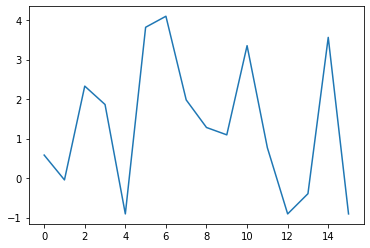

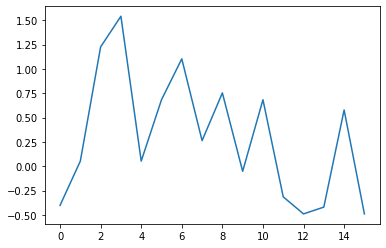

In [41]:
a = [-0.403049,      0.052572,       1.226670,       1.542099,
0.052572,       0.683430,       1.104003,       0.262858,
0.753526,       -0.052572,      0.683430,       -0.315429,
-0.490668,      -0.420572,      0.578287,       -0.490668]
plt.plot(a)

In [55]:
XTest[0]

array([[1.3827115e-01, 1.8412066e-01, 1.0500000e+01, 5.8025795e-01],
       [1.2719014e-01, 1.6211139e-01, 1.0500000e+01, 5.9811509e-01],
       [2.4793699e+00, 1.6213020e+00, 1.0500000e+01, 6.1597222e-01],
       [1.3003321e-01, 4.5519435e-01, 1.0500000e+01, 6.3382936e-01],
       [1.8221194e-01, 4.4556227e-01, 1.0500000e+01, 6.5168649e-01],
       [1.9173019e-01, 1.1524727e+00, 1.0500000e+01, 6.6954362e-01],
       [4.0685434e+00, 2.6394897e+00, 1.0500000e+01, 6.8740082e-01],
       [1.3875852e+00, 1.1869078e+00, 1.0500000e+01, 7.0525795e-01],
       [1.3405173e-01, 2.0265453e-01, 1.3200000e+01, 7.2311509e-01],
       [1.2888390e-01, 2.0931739e-01, 1.3200000e+01, 7.4097222e-01],
       [1.5737653e+00, 1.6472565e+00, 1.3200000e+01, 7.5882936e-01],
       [1.3126786e-01, 3.6385565e+00, 1.3200000e+01, 7.7668649e-01],
       [1.3279726e-01, 2.3358021e+00, 1.3200000e+01, 7.9454362e-01],
       [3.4468296e-01, 1.9885634e+00, 1.3200000e+01, 8.1240082e-01],
       [2.9863911e+00, 2.0489938e+

In [48]:
output_data = np.zeros((1,40,16))
for i in range(40):
    model.set_tensor(input_details[0]['index'], XTest[0:1,i:i+1,:])
    model.invoke()
    output_data[0,i,:] = model.get_tensor(output_details[0]['index'])

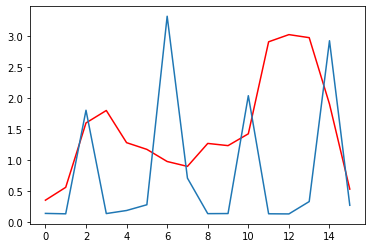

In [50]:
i = 39
plt.plot(output_data[0,i],'r')
plt.plot(YTest[0,i])

In [3]:
class TestModel(tf.Module):
  def __init__(self):
    super(TestModel, self).__init__()

  @tf.function(input_signature=[tf.TensorSpec(shape=[1, 10], dtype=tf.float32)])
  def add(self, x):
    '''
    Simple method that accepts single input 'x' and returns 'x' + 4.
    '''
    # Name the output 'result' for convenience.
    return {'result' : x + 4}


SAVED_MODEL_PATH = 'content/saved_models/test_variable'
TFLITE_FILE_PATH = 'content/test_variable.tflite'

# Save the model
module = TestModel()
# You can omit the signatures argument and a default signature name will be
# created with name 'serving_default'.
tf.saved_model.save(
    module, SAVED_MODEL_PATH,
    signatures={'my_signature':module.add.get_concrete_function()})

# Convert the model using TFLiteConverter
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_PATH)
tflite_model = converter.convert()
with open(TFLITE_FILE_PATH, 'wb') as f:
  f.write(tflite_model)

# Load the TFLite model in TFLite Interpreter
interpreter = tf.lite.Interpreter(TFLITE_FILE_PATH)
# There is only 1 signature defined in the model,
# so it will return it by default.
# If there are multiple signatures then we can pass the name.
my_signature = interpreter.get_signature_runner()

# my_signature is callable with input as arguments.
output = my_signature(x=tf.constant([1.0], shape=(1,10), dtype=tf.float32))
# 'output' is dictionary with all outputs from the inference.
# In this case we have single output 'result'.
print(output['result'])

INFO:tensorflow:Assets written to: content/saved_models/test_variable\assets
[[5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]]
